In [1]:
%reload_ext autoreload
%autoreload 2

import os
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import keras
from keras import layers, ops
from src.EEGNet.data.dataloader import EEGNetDataModule
from src.EEGNet.models import MultiInputModel

## MultiModal

In [2]:
# data
datamodule = EEGNetDataModule(n_subjects=2, split_type='subject').prepare_data()

model = MultiInputModel(input_shape=(128, 61,))

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(name='loss'),
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

# prepare data
y_train = datamodule.train_dataset.pop('y').argmax(axis=1)
X_train = datamodule.train_dataset

# train
history = model.fit(x=X_train, y=y_train, epochs=3)

# evaluate
model.evaluate(datamodule.val_dataset, y=datamodule.val_dataset['y'].argmax(axis=1))


Epoch 1/3
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0778

/opt/homebrew/Caskroom/miniforge/base/envs/eegnet-keras3/lib/python3.11/site-packages/keras/src/backend/torch/optimizers/torch_sgd.py:36: UserWarning: The operator 'aten::_foreach_add_.List' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1712608632396/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  torch._foreach_add_(variables, grads, alpha=-learning_rate)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0526
Epoch 2/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 4.9530e-04
Epoch 3/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.3815e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0025


[0.002033150987699628, 1.0]

## GAN

In [3]:
from src.EEGNet.models.gan_goodfellow import GAN
import numpy as np
import torch
from src.EEGNet.data.mock_temporal_data import MockTemporalData

# data
data = MockTemporalData(n_samples=20, n_features=2, n_timepoints=100)
x, _ = data()
x = x.astype(np.float32)

model = GAN(time=100, features=2)
# model.train(x, epochs=1, batch_size=20, sample_interval=100)

/opt/homebrew/Caskroom/miniforge/base/envs/eegnet-keras3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/eegnet-keras3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


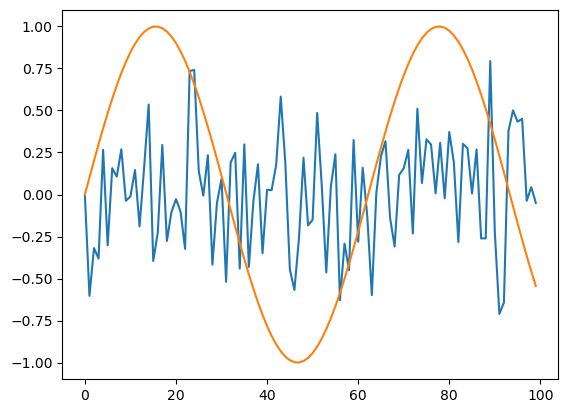

In [7]:
x_gen = model.generator(torch.rand(1, 100))
from matplotlib import pyplot as plt
plt.plot(x_gen.detach().cpu().numpy()[0, :, 1])
plt.plot(x[0, :, 1])
plt.show()
# plt.imshow(x_gen.detach().cpu().numpy().reshape(128, 61))

## Simple GAN

In [13]:
from src.EEGNet.models.gan import SimpleGAN
from src.EEGNet.data.mock_temporal_data import MockTemporalData
from src.EEGNet.utils import ProgressBarCallback
from tqdm.auto import tqdm

max_epochs = 10000
n_features = 1
latent_dim = 64

reusable_pbar = tqdm(total=max_epochs, unit='epoch', leave=False, dynamic_ncols=True)

# data
data = MockTemporalData(n_samples=20, n_features=n_features, n_timepoints=100)
x, _ = data()

model = SimpleGAN(time_dim=100, feature_dim=n_features, latent_dim=latent_dim)
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              d_optimizer=keras.optimizers.Adam(0.001),
              g_optimizer=keras.optimizers.Adam(0.001))

history = model.fit(
    x,
    epochs=max_epochs,
    verbose=0, # type: ignore
    shuffle=True,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='d_loss', mode='min', patience=1000),
        keras.callbacks.CSVLogger('tmp/keras_logs/simple_gan_v1.csv'),
        ProgressBarCallback(n_epochs=max_epochs, n_runs=1, run_index=0, reusable_pbar=reusable_pbar),
    ]
)

  0%|          | 0/10000 [00:00<?, ?epoch/s]

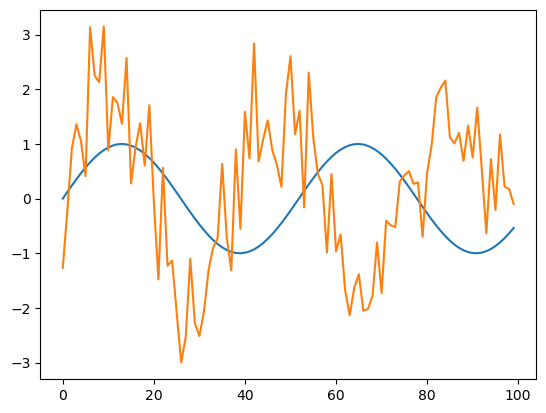

In [21]:
from matplotlib import pyplot as plt
subject_to_plot = 0
feature_to_plot = 0
plt.plot(x[subject_to_plot, :, feature_to_plot])
noise = keras.random.normal((1, latent_dim))
x_gen = model.generator(noise)
plt.plot(x_gen[subject_to_plot, :, feature_to_plot].cpu().detach().numpy().squeeze())
plt.show()